<a href="https://colab.research.google.com/github/lgiesen/forest-height/blob/main/random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
from google.colab import drive
drive.mount ('/content/drive', force_remount=True)
root_path = 'drive/MyDrive/Colab Notebooks/data/'

Mounted at /content/drive


In [2]:
!unzip "drive/MyDrive/Colab Notebooks/data/images_train.zip"
!unzip "drive/MyDrive/Colab Notebooks/data/masks_train.zip"

Archive:  drive/MyDrive/Colab Notebooks/data/images_train.zip
  inflating: images/image_000.npy    
  inflating: images/image_001.npy    
  inflating: images/image_002.npy    
  inflating: images/image_003.npy    
  inflating: images/image_004.npy    
  inflating: images/image_005.npy    
  inflating: images/image_006.npy    
  inflating: images/image_007.npy    
  inflating: images/image_008.npy    
  inflating: images/image_009.npy    
  inflating: images/image_010.npy    
  inflating: images/image_011.npy    
  inflating: images/image_012.npy    
  inflating: images/image_013.npy    
  inflating: images/image_014.npy    
  inflating: images/image_015.npy    
  inflating: images/image_016.npy    
  inflating: images/image_017.npy    
  inflating: images/image_018.npy    
  inflating: images/image_019.npy    
Archive:  drive/MyDrive/Colab Notebooks/data/masks_train.zip
  inflating: masks/mask_000.npy      
  inflating: masks/mask_001.npy      
  inflating: masks/mask_002.npy      
  i

In [3]:
path_images = root_path + 'images/'
path_masks = root_path + 'masks/'

In [4]:
from os.path import isfile, join
from os import listdir
def get_files(dir):
  onlyfiles = [f for f in listdir(dir) if isfile(join(dir, f))]
  return onlyfiles

In [5]:
import numpy as np
X = np.load('/content/images/' + get_files(path_images)[0])

for filename in get_files(path_images)[1:]:
    temp = np.load('/content/images/' + filename, allow_pickle=True)
    X = np.concatenate((X, temp))
del temp

In [6]:
num_color_channels = int(X.shape[0]/len(get_files(path_images)))
num_images = int(X.shape[0]/num_color_channels)
X = np.reshape(X, (num_images, num_color_channels, X.shape[1], X.shape[2]))
# X.shape: (20, 10, 1024, 1024)
del num_color_channels, num_images

In [7]:
y = np.load('/content/masks/' + get_files(path_masks)[0])

for filename in get_files(path_masks)[1:]:
    temp = np.load('/content/masks/' + filename, allow_pickle=True)
    y = np.concatenate((y, temp))
del temp

In [8]:
# remove drive connection as it is no longer needed
drive.flush_and_unmount()

In [9]:
# ceil the values at 2000 because clouds have a different reflection value
ceiling = 2000
X[X > ceiling] = ceiling
#scale values between 0 and 1
X = X/ceiling

Alternative loading and storing of data:
```
# create data sets by combining npy files
path_train_sat = root_path + "train_satellite.npy"
path_train_masks = root_path + "train_masks.npy"

from os import listdir
if not isfile(path_train_sat):
  print("train satellite dataset is generated")
  # image set
  # initialize with the first satellite image
  train_satellite = np.load(path_images + listdir(path_images)[0])
  # concatinate all other images
  for f in listdir(path_images)[1:]:
      current_array = np.load(path_images + f, allow_pickle=True)
      train_satellite = np.concatenate((train_satellite, current_array), axis=0)
  # adjust incorrect shape: (200, 1024, 1024)
  train_satellite = train_satellite.reshape(20, 10, 1024, 1024)
  # save as file
  np.save(path_train_sat, train_satellite, allow_pickle=True, fix_imports=True)
if not isfile(path_train_masks):
  print("train masks dataset is generated")
  # masks
  # initialize with the first mask image
  train_masks = np.load(path_masks + listdir(path_masks)[0])
  # concatinate all other images
  for f in listdir(path_masks)[1:]:
      current_array = np.load(path_masks + f, allow_pickle=True)
      train_masks = np.concatenate((train_masks, current_array), axis=0)
  # save as file
  np.save(root_path + "train_masks.npy", train_masks, allow_pickle=True, fix_imports=True)
  ```

# Handling Large Images: Creating Cutouts
Split the large image into smaller sub-images. Use these for training and prediction.

In [10]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from patchify import patchify, unpatchify

patch_shape = (10, 256, 256) # needs to have the same number of dimensions as the whole image
step_size = 256 # cuurently exact cropping of images with no overlap

# patchify has to be executed for each image individually
# initialize all patches with patches from first image. Then add all other patches
first_patches = patchify(X[0], patch_shape, step=step_size)
all_patches = first_patches
for idx in range(1, X.shape[0]):
  img = X[idx]
  patches = patchify(img, patch_shape, step=step_size)
  # add all other patches
  all_patches = np.concatenate((all_patches, patches))

In [12]:
# check if patch shape is as planned
assert all_patches.shape == (20, 4, 4, 10, 256, 256)

check if the original image can be reconstructed:

In [13]:
all_reconstructed_images = unpatchify(first_patches, X[0].shape)
for idx in range(1, X.shape[0]):
  #select single patch to unpatchify it
  patches = np.expand_dims(all_patches[idx], 0)
  reconstructed_image = unpatchify(patches, X[0].shape)
  all_reconstructed_images = np.concatenate((all_reconstructed_images, reconstructed_image))

all_reconstructed_images = np.reshape(all_reconstructed_images, X.shape)

In [14]:
# check if unpatchify worked
assert (all_reconstructed_images == X).all()

In [15]:
del all_reconstructed_images, reconstructed_image

In [16]:
# put x and y axis patches together
all_patches = np.reshape(all_patches, (all_patches.shape[0] * (all_patches.shape[1]*all_patches.shape[2]), all_patches.shape[3], all_patches.shape[4], all_patches.shape[5]))

In [17]:
all_patches.shape

(320, 10, 256, 256)

In [18]:
mask_patch_shape = (patch_shape[1], patch_shape[2]) # adjust to mask dimensions

# patchify has to be executed for each image individually
# initialize all patches with patches from first image. Then add all other patches
all_mask_patches = patchify(y[0], mask_patch_shape, step=step_size)
for idx in range(1, y.shape[0]):
  img = y[idx]
  patches = patchify(img, mask_patch_shape, step=step_size)
  # add all other patches
  all_mask_patches = np.concatenate((all_mask_patches, patches))
del patches

In [19]:
all_mask_patches = np.reshape(all_mask_patches, (y.shape[0] * (all_mask_patches.shape[1]**2), all_mask_patches.shape[2], all_mask_patches.shape[3]))

In [20]:
def normalize_color(img):
  assert len(img.shape) == 3
  # Extract Red, Green, and Blue bands
  red = img[2, :, :]
  green = img[1, :, :]
  blue = img[0, :, :]

  # Normalize the bands to [0, 1] range
  red_norm = (red - red.min()) / (red.max() - red.min())
  green_norm = (green - green.min()) / (green.max() - green.min())
  blue_norm = (blue - blue.min()) / (blue.max() - blue.min())

  return np.stack((red_norm, green_norm, blue_norm), axis=-1)

In [21]:
import matplotlib.pyplot as plt
def plot(img):
    #satellite image
    if(len(img.shape) == 3):
      img = normalize_color(img)

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Data Augmentation

In [22]:
import tensorflow as tf
from tensorflow import keras
#Data augmentation
data_augmentation = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    #keras.layers.experimental.preprocessing.RandomRotation(0.4),
    #keras.layers.RandomCrop(224, 224)
])

In [23]:
image = normalize_color(all_patches[0][:3])

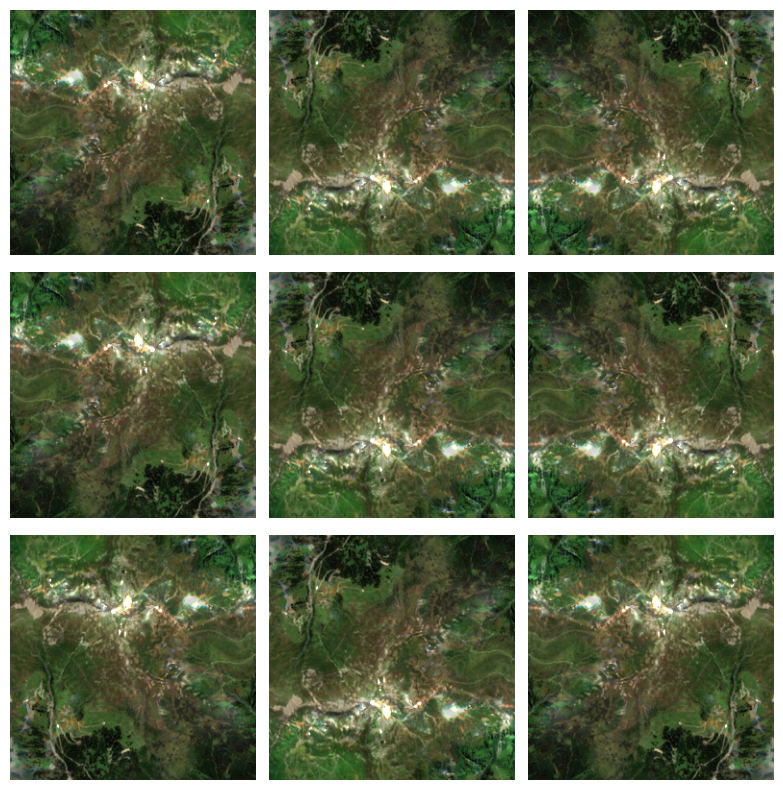

In [24]:
#image = tf.cast(tf.expand_dims(image, 0), tf.float32)
plt.figure(figsize=(10, 10))

for i in range(9):
  augmented_image = data_augmentation(image, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.subplots_adjust(hspace=0.07, wspace=0.01)
  plt.imshow(augmented_image)
  plt.axis("off")
  #print(augmented_image.shape)
  #print(i)
  #plot_img(augmented_image)

del augmented_image, image

# Dataset Generation

In [25]:
#conversion to tensors
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((all_patches, all_mask_patches))

In [26]:
dataset.element_spec

(TensorSpec(shape=(10, 256, 256), dtype=tf.float64, name=None),
 TensorSpec(shape=(256, 256), dtype=tf.float64, name=None))

# Random Forest Regression

In [27]:
del dataset

In [28]:
#early stopping rounds with large epochs: lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

# K-fold crossvalidation (k=5)
# RandomizedSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [29]:
X = np.reshape(all_patches, (320*256*256, 10))
del all_patches
y=np.reshape(all_mask_patches, (320*256*256))
del all_mask_patches

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)
del X, y

In [86]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [100, 200, 500] #[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               #'min_samples_split': min_samples_split,
               #'min_samples_leaf': min_samples_leaf,
               #'criterion': ['mse', 'mae'],
               'bootstrap': bootstrap}

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
# initialize model
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# train model
rf_random.fit(X_train[:10], y_train[:10])

In [35]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [37]:
y_pred = rf_random.predict(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV
random_forest_tuning = RandomForestRegressor(random_state = 42)
param_grid = {
   'n_estimators': [100, 200, 500],
   'max_features': ['auto', 'sqrt', 'log2'],
   'max_depth' : [4,5,6,7,8],
   'criterion' :['mse', 'mae']
}
GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
GSCV.fit(X_train, y_train)
GSCV.best_params_

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
# Step 3: Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    all_patches,  # Features
    all_mask_patches,   # Labels
    test_size=0.2,          # Adjust the test size as needed
    random_state=42         # Set a random seed for reproducibility
)
del all_patches, all_mask_patches

In [ ]:
assert len(X_train.shape) == 4
nsamples, color_channels, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples, color_channels*nx*ny))

In [ ]:
assert len(y_train.shape) == 3
nsamples, nx, ny = y_train.shape
y_train = y_train.reshape((nsamples, nx*ny))